In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
p_gwl = Path("../data/AquiMod_simobs_Gretna.csv")
p_met = Path("../data/ukcp18_simobs_Gretna.csv")
df_gwl = pd.read_csv(p_gwl, parse_dates=["Date"], dayfirst=True)
df_met = pd.read_csv(p_met, parse_dates=["Date"], dayfirst=True)
df_data = pd.merge(left=df_met, right=df_gwl, on=["Borehole", "Model", "Date"], how="inner").dropna()
df_data

,Borehole,Model,Date,precipwsnow,PET,Sim,Obs
11419,Gretna,AquiMod,1993-04-07,0.096710,1.530000,39.9447,40.084
11420,Gretna,AquiMod,1993-04-08,22.228661,1.530000,39.9812,40.082
11421,Gretna,AquiMod,1993-04-09,9.274128,1.530000,40.0087,40.106
11422,Gretna,AquiMod,1993-04-10,0.089421,1.530000,40.0106,40.121
11423,Gretna,AquiMod,1993-04-11,1.071286,1.530000,40.0064,40.135
...,...,...,...,...,...,...,...
20814,Gretna,AquiMod,2018-12-27,0.153541,0.248387,39.9721,39.959
20815,Gretna,AquiMod,2018-12-28,1.296672,0.248387,39.9695,39.953
20816,Gretna,AquiMod,2018-12-29,1.978836,0.248387,39.9697,39.950
20817,Gretna,AquiMod,2018-12-30,0.029849,0.248387,39.9671,39.941


I should plot this dataset here

In [3]:
fig1 = px.line(df_data, x="Date", y="Obs")
fig1.show()
fig2 = px.line(df_data, x="Date", y="precipwsnow")
fig2.show()
fig3 = px.line(df_data, x="Date", y="PET")
fig3.show()

In [4]:
precip = df_data["precipwsnow"].values
pet = df_data["PET"].values
gwl = df_data["Obs"].values

In [5]:
# Concatenate the features
features_arr = np.column_stack((precip, pet))
features_arr.shape

(9400, 2)

In [6]:
# Normalize the features
scaler = MinMaxScaler(feature_range=(-1, 1))
features_scaled_arr = scaler.fit_transform(features_arr)
features_scaled_arr.shape

(9400, 2)

In [7]:
def create_sequences(data, seq_length):
    """
    Transforms time-series data into sequences of a specified length.

    Parameters:
    data (np.array): A 2D numpy array where each row is a time step and each column is a feature.
    seq_length (int): The number of time steps to include in each output sequence.

    Returns:
    np.array: A 3D numpy array of shape (num_samples - seq_length + 1, seq_length, num_features).
    """

    xs = []  # Initialise an empty list to store sequences

    # For each possible sequence in the data...
    for i in range(len(data) - seq_length + 1):
        # Extract a sequence of length `seq_length`
        x = data[i:(i+seq_length)]
        # Append the sequence to the list
        xs.append(x)

    # Convert the list of sequences into a 3D numpy array
    return np.array(xs)

seq_length = 10
features_seq_arr = create_sequences(features_scaled_arr, seq_length)
# Also need to make sure the first 365 elements of the gwl array are clipped
gwl_arr = gwl[seq_length - 1:]
print(features_seq_arr.shape)
print(gwl_arr.shape)

(9391, 10, 2)
(9391,)


In [8]:
# Convert to PyTorch tensors
# Note that the target variable, GWL, does not need rescaling
features_tensor: torch.Tensor = torch.from_numpy(features_seq_arr).float()
gwl_tensor: torch.Tensor = torch.from_numpy(gwl_arr).float().unsqueeze(1)
print(features_tensor.shape)
print(gwl_tensor.shape)

torch.Size([9391, 10, 2])
torch.Size([9391, 1])


In [9]:
# Split into training and test sets
train_size = int(len(features_tensor) * 0.8)
test_size = len(features_tensor) - train_size

features_train = features_tensor[:train_size]
features_test = features_tensor[train_size:]
gwl_train  = gwl_tensor[:train_size]
gwl_test = gwl_tensor[train_size:]

print(f"{features_train.shape}: {gwl_train.shape}")
print(f"{features_test.shape}: {gwl_test.shape}")

torch.Size([7512, 10, 2]): torch.Size([7512, 1])
torch.Size([1879, 10, 2]): torch.Size([1879, 1])


In [10]:
features_train.shape

torch.Size([7512, 10, 2])

**CAUTION** the following code block is taken from another video tutorial

When you initialise an instance of TimeSeriesDataset, you pass in X and y. Here, X is expected to be a 2D array-like object where each row is a separate sample and each column is a separate feature. So, if you have multiple features, X would have multiple columns.

The __getitem__ method returns the i-th sample and its corresponding target value. This will be a tuple, where the first element is a 1D array (the feature vector for the i-th sample) and the second element is the target value.

When you use this dataset to train your LSTM, each sample (which could contain multiple features) will be an input to the LSTM. Just ensure that the input_size parameter of your LSTM matches the number of features in your data. 😊

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

# Work on this tomorrow
train_dataset = TimeSeriesDataset(features_train, gwl_train)
test_dataset = TimeSeriesDataset(features_test, gwl_test)


batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Explore the dataloader
for batch in train_loader:
    print(type(batch), ": ", len(batch))
    print(batch[0].shape)
    print(batch[1].shape)
    break

<class 'list'> :  2
torch.Size([16, 10, 2])
torch.Size([16, 1])


`nn.Linear` is a class in PyTorch that applies a linear transformation to the incoming data. It's often referred to as a fully connected layer or a dense layer in neural networks. The transformation it applies is: `y = xA^T + b`, where `x` is the input, `A` is the weight matrix, `b` is the bias, and `y` is the output.

In your LSTM model, the `nn.Linear` layer is used at the end of the network. The reason for this is to transform the output of the LSTM layers to the desired output shape. 

In the case of your code, the LSTM layers output a tensor of shape `(batch_size, seq_length, hidden_size)`. The `nn.Linear` layer transforms this to `(batch_size, seq_length, output_size)`. In your specific case, `output_size` is 1 because you're doing a regression task (predicting groundwater levels), so you want a single continuous value as output for each sequence in the batch.

So, the LSTM layers learn the temporal dynamics of the data, and the final linear layer maps these learned features to the target variable (groundwater levels in your case). This is a common architecture in many tasks involving sequence data. 😊

In the context of Long Short-Term Memory (LSTM) networks, `h` and `c` represent the hidden state and the cell state, respectively.

- **Hidden State (`h`)**: This is the output of the LSTM unit. It's a function of the current input and the previous cell state. The hidden state can be used for predictions, and is also passed to the LSTM unit at the next time step.

- **Cell State (`c`)**: This is the "memory" of the LSTM unit. It stores long-term information. The cell state is updated at each time step by removing (forgetting) irrelevant parts and adding (storing) relevant parts of the current input and the previous hidden state.

The ability to update and manipulate these states allows the LSTM to learn and remember over long sequences, and to handle issues like vanishing and exploding gradients that can occur in traditional recurrent neural networks (RNNs). 😊

The batch_first argument in nn.LSTM is a boolean flag that changes the expected input format.

If batch_first is set to False (which is the default), the expected input shape is (seq_len, batch, input_size). Here, seq_len is the length of the sequence, batch is the batch size, and input_size is the number of features.

If batch_first is set to True, the expected input shape is (batch, seq_len, input_size). This is often more convenient and matches the ordering used by other parts of PyTorch, like the nn.Linear layer.

In your code, batch_first=True is used, which means your LSTM expects input tensors where the batch size is the first dimension. 😊

The line `self.lstm(x, (h0, c0))` is where the input tensor `x` and the initial hidden and cell states `(h0, c0)` are passed into the LSTM layer.

Here's a breakdown:

- `x` is the input tensor, which should have the shape `(batch_size, seq_length, input_size)` if `batch_first=True`, or `(seq_length, batch_size, input_size)` if `batch_first=False`.

- `(h0, c0)` are the initial hidden and cell states for the LSTM. `h0` and `c0` are both tensors of shape `(num_layers, batch_size, hidden_size)`. They are usually initialized to zeros, but can be set to other values for specific use cases.

The `self.lstm(x, (h0, c0))` call returns two outputs:

1. `out`: A tensor containing the output features from the LSTM. If `batch_first=True`, it will have the shape `(batch_size, seq_length, hidden_size)`. If `batch_first=False`, it will have the shape `(seq_length, batch_size, hidden_size)`.

2. `(hn, cn)`: Tensors containing the hidden and cell states for `t = seq_len`. These are useful when the LSTM is part of a larger network and its final states are needed for further computation.

In your code, the `out` tensor is passed to a fully connected layer (`self.fc`) to get the final output of the model, while `(hn, cn)` are not used. 😊

In [12]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [13]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
# Initialize the model, loss function, and optimizer
model = LSTM(input_size=2, hidden_size=5, num_layers=1, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
for batch_index, batch in enumerate(train_loader):
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([16, 10, 2])
torch.Size([16, 1])


In [16]:
# Training function
def train_epoch(epoch: int):
    model.train()
    print(f'Epoch: {epoch + 1}')
    for batch in train_loader:
        running_loss = 0
        # batch is a list with two elements
        # The first element is the feature array
        # The second element is the GWL array
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        output = model(x_batch)
        loss = criterion(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    avg_loss_across_batches = round(running_loss)
    print(f'Final Batch, Loss: {running_loss}')



In [17]:
# Testing
def test_epoch():
    model.eval()
    running_loss = 0
    for i, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            output = model(x_batch)
            loss = criterion(output, y_batch)
            running_loss += loss.item()
    avg_loss_across_batches = running_loss / len(test_loader)
    
    print(f'Test Loss: {avg_loss_across_batches}')
    print('***************************************************')
    print()

Epoch: 1
Final Batch, Loss: 1323.001708984375
Test Loss: 1318.8799924688824
***************************************************



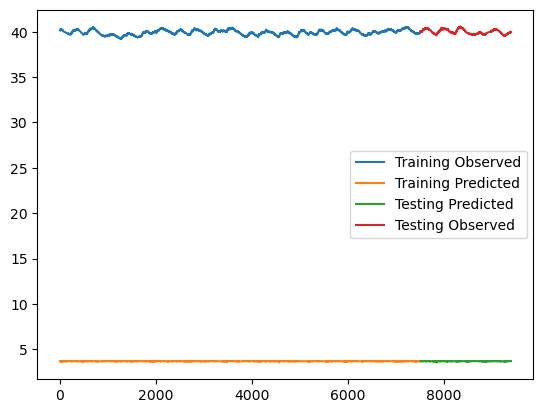

Epoch: 2
Final Batch, Loss: 1106.2823486328125
Test Loss: 1102.2030132746293
***************************************************

Epoch: 3
Final Batch, Loss: 929.8547973632812
Test Loss: 926.0298265360169
***************************************************

Epoch: 4
Final Batch, Loss: 777.4222412109375
Test Loss: 773.8920313948291
***************************************************

Epoch: 5
Final Batch, Loss: 644.0009765625
Test Loss: 640.7753151069253
***************************************************

Epoch: 6
Final Batch, Loss: 527.0379028320312
Test Loss: 524.1167664608713
***************************************************

Epoch: 7
Final Batch, Loss: 424.89776611328125
Test Loss: 422.27718366202663
***************************************************

Epoch: 8
Final Batch, Loss: 336.38897705078125
Test Loss: 334.0629924192267
***************************************************

Epoch: 9
Final Batch, Loss: 260.55340576171875
Test Loss: 258.51449675479176
*************************

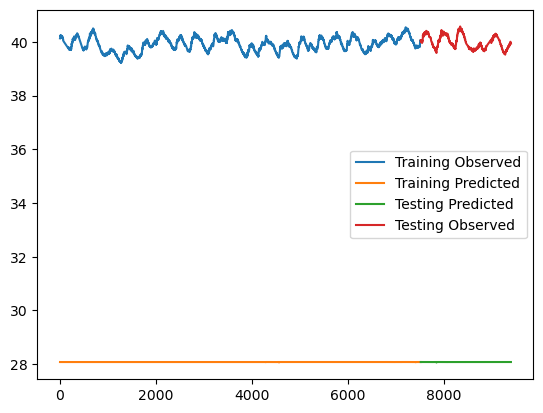

Epoch: 12
Final Batch, Loss: 100.84829711914062
Test Loss: 99.61001502861411
***************************************************

Epoch: 13
Final Batch, Loss: 67.46320343017578
Test Loss: 66.46518354900813
***************************************************

Epoch: 14
Final Batch, Loss: 42.46185302734375
Test Loss: 41.68642435235492
***************************************************

Epoch: 15
Final Batch, Loss: 24.746009826660156
Test Loss: 24.17207653239622
***************************************************

Epoch: 16
Final Batch, Loss: 13.079489707946777
Test Loss: 12.682175086716475
***************************************************

Epoch: 17
Final Batch, Loss: 6.111035346984863
Test Loss: 5.861546178995552
***************************************************

Epoch: 18
Final Batch, Loss: 2.4541335105895996
Test Loss: 2.320537318617611
***************************************************

Epoch: 19
Final Batch, Loss: 0.8310391902923584
Test Loss: 0.7803849068991209
**************

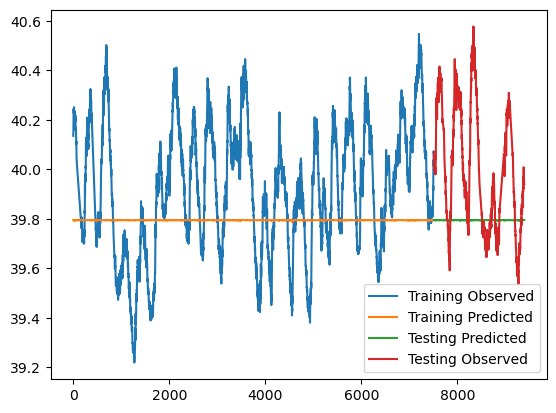

Epoch: 22
Final Batch, Loss: 0.02716883271932602
Test Loss: 0.0696002979231584
***************************************************

Epoch: 23
Final Batch, Loss: 0.016312111169099808
Test Loss: 0.06331535865406218
***************************************************

Epoch: 24
Final Batch, Loss: 0.012818652205169201
Test Loss: 0.06160655112645314
***************************************************

Epoch: 25
Final Batch, Loss: 0.010586891323328018
Test Loss: 0.060647083177543006
***************************************************

Epoch: 26
Final Batch, Loss: 0.008357202634215355
Test Loss: 0.05983504601638326
***************************************************

Epoch: 27
Final Batch, Loss: 0.006093233823776245
Test Loss: 0.05922771319653247
***************************************************

Epoch: 28
Final Batch, Loss: 0.004005377646535635
Test Loss: 0.05897945426002449
***************************************************

Epoch: 29
Final Batch, Loss: 0.0023182500153779984
Test Loss: 0

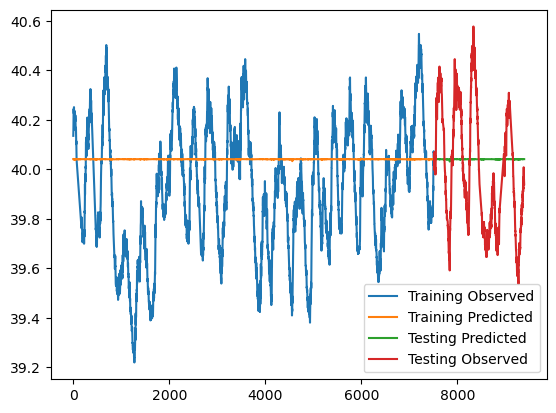

Epoch: 32
Final Batch, Loss: 0.00022902441560290754
Test Loss: 0.06176274304250571
***************************************************

Epoch: 33
Final Batch, Loss: 0.00017361578647978604
Test Loss: 0.06266615109767773
***************************************************

Epoch: 34
Final Batch, Loss: 0.00021687198022846133
Test Loss: 0.06339281319292317
***************************************************

Epoch: 35
Final Batch, Loss: 0.00028790475334972143
Test Loss: 0.06393083010112544
***************************************************

Epoch: 36
Final Batch, Loss: 0.0003546721418388188
Test Loss: 0.06430567274515328
***************************************************

Epoch: 37
Final Batch, Loss: 0.00040735298534855247
Test Loss: 0.06455442481141506
***************************************************

Epoch: 38
Final Batch, Loss: 0.0004464615194592625
Test Loss: 0.06471321797412741
***************************************************

Epoch: 39
Final Batch, Loss: 0.0004756506823468953

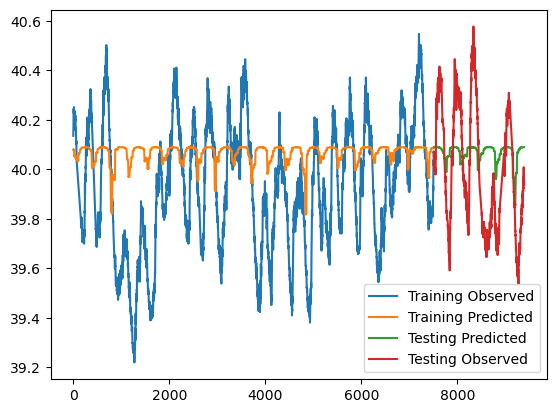

Epoch: 42
Final Batch, Loss: 0.0015985997160896659
Test Loss: 0.05870297168563041
***************************************************

Epoch: 43
Final Batch, Loss: 0.0018789059249684215
Test Loss: 0.058556717618711895
***************************************************

Epoch: 44
Final Batch, Loss: 0.001997369807213545
Test Loss: 0.05859964137297061
***************************************************

Epoch: 45
Final Batch, Loss: 0.002047743182629347
Test Loss: 0.0586919557264714
***************************************************

Epoch: 46
Final Batch, Loss: 0.002069431124255061
Test Loss: 0.058804685658858144
***************************************************

Epoch: 47
Final Batch, Loss: 0.002070943359285593
Test Loss: 0.058932471279966474
***************************************************

Epoch: 48
Final Batch, Loss: 0.0020577223040163517
Test Loss: 0.05906552167301524
***************************************************

Epoch: 49
Final Batch, Loss: 0.002037930767983198
Test Lo

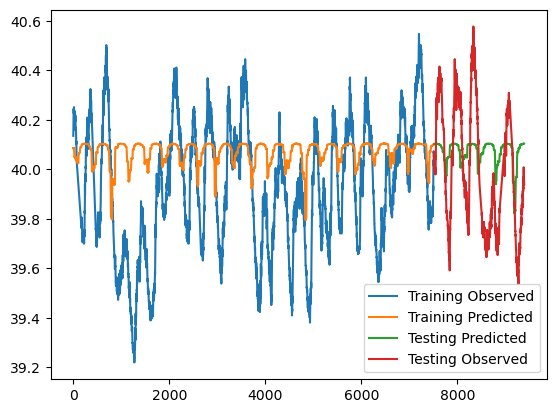

Epoch: 52
Final Batch, Loss: 0.0020198565907776356
Test Loss: 0.059455772893408594
***************************************************

Epoch: 53
Final Batch, Loss: 0.002034404082223773
Test Loss: 0.0595056915954663
***************************************************

Epoch: 54
Final Batch, Loss: 0.002053353935480118
Test Loss: 0.05954252081031327
***************************************************

Epoch: 55
Final Batch, Loss: 0.002076378557831049
Test Loss: 0.05957060257837145
***************************************************

Epoch: 56
Final Batch, Loss: 0.002101070247590542
Test Loss: 0.05959103275825451
***************************************************

Epoch: 57
Final Batch, Loss: 0.00212454074062407
Test Loss: 0.0596031080600924
***************************************************

Epoch: 58
Final Batch, Loss: 0.0021471036598086357
Test Loss: 0.05960728197853807
***************************************************

Epoch: 59
Final Batch, Loss: 0.0021703881211578846
Test Loss: 

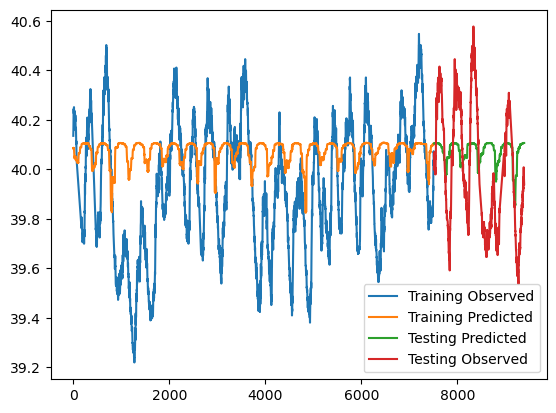

Epoch: 62
Final Batch, Loss: 0.002238920424133539
Test Loss: 0.05956988535294609
***************************************************

Epoch: 63
Final Batch, Loss: 0.002263406291604042
Test Loss: 0.05954879732216487
***************************************************

Epoch: 64
Final Batch, Loss: 0.0022876604925841093
Test Loss: 0.05952282676446623
***************************************************

Epoch: 65
Final Batch, Loss: 0.0023143466096371412
Test Loss: 0.0594938445428852
***************************************************

Epoch: 66
Final Batch, Loss: 0.002340368926525116
Test Loss: 0.05946052730649757
***************************************************

Epoch: 67
Final Batch, Loss: 0.002368905581533909
Test Loss: 0.05943262556067597
***************************************************

Epoch: 68
Final Batch, Loss: 0.0023973167408257723
Test Loss: 0.05940116494321817
***************************************************

Epoch: 69
Final Batch, Loss: 0.0024277358315885067
Test Loss

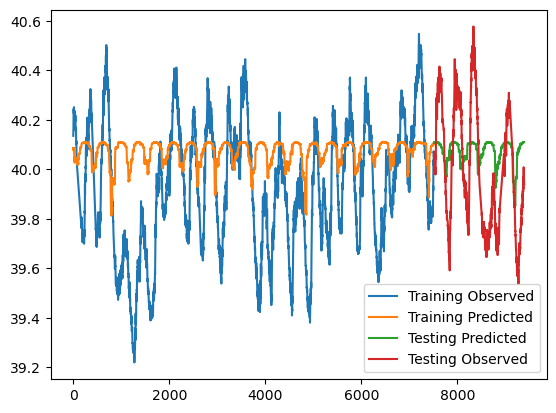

Epoch: 72
Final Batch, Loss: 0.0025213579647243023
Test Loss: 0.05930122793666916
***************************************************

Epoch: 73
Final Batch, Loss: 0.0025535901077091694
Test Loss: 0.05928463143542196
***************************************************

Epoch: 74
Final Batch, Loss: 0.0025860262103378773
Test Loss: 0.05926778009733564
***************************************************

Epoch: 75
Final Batch, Loss: 0.0026182918809354305
Test Loss: 0.059256082936387386
***************************************************

Epoch: 76
Final Batch, Loss: 0.0026509391609579325
Test Loss: 0.059245422093288466
***************************************************

Epoch: 77
Final Batch, Loss: 0.002682474907487631
Test Loss: 0.05923751823187774
***************************************************

Epoch: 78
Final Batch, Loss: 0.002714132657274604
Test Loss: 0.05923183672440878
***************************************************

Epoch: 79
Final Batch, Loss: 0.002745774108916521
Test 

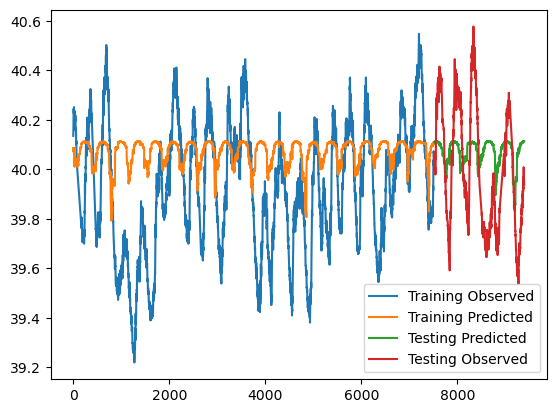

Epoch: 82
Final Batch, Loss: 0.002835415303707123
Test Loss: 0.05922369892665548
***************************************************

Epoch: 83
Final Batch, Loss: 0.0028629766311496496
Test Loss: 0.059230793375517954
***************************************************

Epoch: 84
Final Batch, Loss: 0.0028888110537081957
Test Loss: 0.059224728422862936
***************************************************

Epoch: 85
Final Batch, Loss: 0.002915084594860673
Test Loss: 0.059234396735072074
***************************************************

Epoch: 86
Final Batch, Loss: 0.0029383827932178974
Test Loss: 0.059228582475166686
***************************************************

Epoch: 87
Final Batch, Loss: 0.00296291196718812
Test Loss: 0.05923640486114398
***************************************************

Epoch: 88
Final Batch, Loss: 0.0029843542724847794
Test Loss: 0.05923222242834804
***************************************************

Epoch: 89
Final Batch, Loss: 0.0030074454843997955
Test

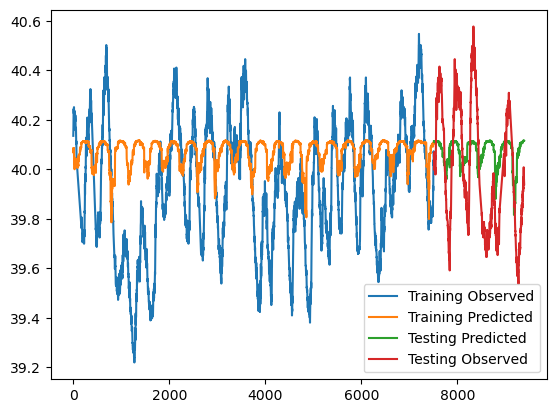

Epoch: 92
Final Batch, Loss: 0.0030664338264614344
Test Loss: 0.059239497355489314
***************************************************

Epoch: 93
Final Batch, Loss: 0.0030861198902130127
Test Loss: 0.05924485699605134
***************************************************

Epoch: 94
Final Batch, Loss: 0.0031030443497002125
Test Loss: 0.059242638930485
***************************************************

Epoch: 95
Final Batch, Loss: 0.003120224457234144
Test Loss: 0.059245734346805586
***************************************************

Epoch: 96
Final Batch, Loss: 0.003136030398309231
Test Loss: 0.05924374618275501
***************************************************

Epoch: 97
Final Batch, Loss: 0.00315204169601202
Test Loss: 0.05924570654524822
***************************************************

Epoch: 98
Final Batch, Loss: 0.003166439477354288
Test Loss: 0.05924328821869093
***************************************************

Epoch: 99
Final Batch, Loss: 0.0031811040826141834
Test Loss

In [18]:
num_epochs = 100
for epoch in range(num_epochs):
    train_epoch(epoch)
    test_epoch()
    if epoch % 10 != 0:
        continue
    with torch.no_grad():
        train_predicted = model(features_train.to(device)).to('cpu').numpy()
        test_predicted = model(features_test.to(device)).to('cpu').numpy()
    plt.plot(gwl_train, label="Training Observed")
    plt.plot(train_predicted, label="Training Predicted")
    plt.plot(np.append(np.full(len(gwl_train), np.nan), test_predicted), label="Testing Predicted")
    plt.plot(np.append(np.full(len(gwl_train), np.nan), gwl_test), label="Testing Observed")
    plt.legend()
    plt.show()

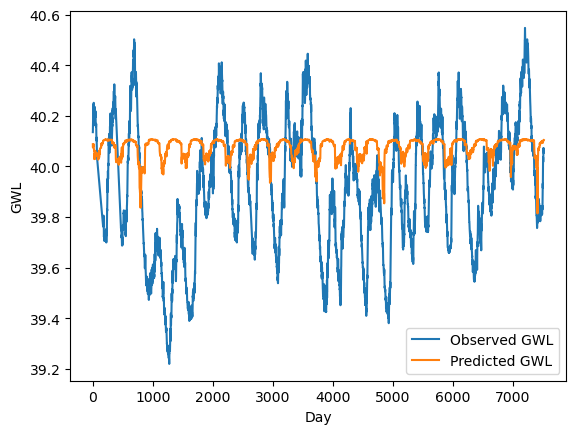

In [38]:
# features_train, gwl_train
# features_test, gwl_test

with torch.no_grad():
    predicted = model(features_train.to(device)).to('cpu').numpy()

plt.plot(gwl_train, label='Observed GWL')
plt.plot(predicted, label='Predicted GWL')
plt.xlabel('Day')
plt.ylabel('GWL')
plt.legend()
plt.show()

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model)} parameters")

The model has 31251 parameters


In the example below, `ArrayModel` is a Pydantic model that expects a single attribute `array` which should be a numpy array. The `check_dimension` method is a validator for `array` that checks if `array` is 2D and if the size of its second dimension is 3. If not, it raises a `ValueError`.

You can use a similar approach to validate PyTorch tensors or other data types. However, keep in mind that this adds an extra layer of complexity to your code, and it might be simpler and more efficient to write custom validation functions, especially for complex data types or validation rules.

I hope this helps! Let me know if you have any other questions. 😊

In [ ]:
from pydantic import BaseModel, validator

class ArrayModel(BaseModel):
    array: np.ndarray

    @validator('array')
    def check_dimension(cls, array):
        if array.ndim != 2 or array.shape[1] != 3:
            raise ValueError('array must be 2D and the size of the second dimension must be 3')
        return array